<a href="https://colab.research.google.com/github/jjfaj/CA683/blob/master/CA683_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CA683 Assignment

Following is the model development for the CA683 assignment

#Import Functions



In [237]:
import pandas as pd
import os
#import pyprind
import logging
import pickle
import numpy as np
import statistics
import seaborn as sns
from numpy import hstack
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import load_model

from datetime import datetime
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, LSTM, Dropout
from tensorflow.keras import Model

from google.colab import drive
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import utils

from statsmodels.tsa.stattools import adfuller
import statsmodels as sm
import statsmodels.api as smx
from statsmodels.tsa.arima_model import ARIMA

import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA683_Assignment/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Definitions

#Load Datasets

In [0]:
#Load Time Series Data
file_path = './Data/'
df_deaths = pd.read_csv(file_path+'time_series_covid_19_deaths.csv')
df_confirmed = pd.read_csv(file_path+'time_series_covid_19_confirmed.csv')
df_recover = pd.read_csv(file_path+'time_series_covid_19_recovered.csv')

In [0]:
#Load Country characteristic data (Population, Density, First Covid Case, etc)
df_country = pd.read_csv(file_path+'covid19_merged.csv')

#Load in the Restrictions per Country
df_restrictions = pd.read_excel(file_path+'Restrictions by Country v2.xlsx')

#Load Worldometer Summary for the Test Cases per million
df_world = pd.read_excel(file_path+'Worldometer Summary.xlsx')

#Data Understanding

#Prepare Data

##SEIR Model

In [0]:
#Prepare the Data for the SEIR model
#Get the Min and Max Date for Restrictions
df_country_tmp = df_restrictions[df_restrictions.columns[:2]].copy()
df_dates = df_restrictions[df_restrictions.columns[-31:]].copy()

df_minmax = pd.concat([df_country_tmp, df_dates.min(axis=1).rename('min_date'), df_dates.max(axis=1).rename('max_date')], axis=1)

In [0]:
#Only focus on countries and not individual territories
df_minmax = df_minmax[df_minmax['location_wiki'].isna()]
df_minmax.drop('location_wiki', axis=1)

In [0]:
#Join the Restrictions & Country data frames
df_result = pd.merge(df_minmax, df_country, left_on='country', right_on='country',how='inner')
df_seir = df_result.filter(['country','min_date','max_date', 'covid19_first_date','Population_2020' ], axis=1)

#Set the Covid19_first_date field to a datetime type to compare to the Min/Max dates of the restrictions
df_seir['covid19_first_date'] = df_seir['covid19_first_date'].astype('datetime64[ns]')

In [0]:
df_seir['Difference'] = df_seir['min_date'].sub(df_seir['covid19_first_date'], axis=0)
df_seir['Difference'] = df_seir['Difference'] / np.timedelta64(1, 'D')

In [0]:
##Looking at the Min/Max dates of when the the restrictions were implemented, it appears
#that there are issues with the quality of the data.  There are some countries where the 
##restrictions were implemented before the first Covid19 case was identified, which is 
#possible, but unlikely.  Because of this, I'm only going to focus on of more than 20 days
df_seir_test = df_seir[df_seir['Difference'] > 20]
df_seir_test

In [0]:
df_minmax

##Prep Time Series for ARIMA

In [0]:
df_transpose = df_deaths
df_transpose = df_transpose.drop(['Lat', 'Long'], axis=1)
df_transpose = df_transpose.fillna('')
df_transpose = df_transpose.drop(['Province/State'], axis=1)
#Need to groupby Province/State to get it by country rather than territory
df_transpose = df_transpose.groupby(['Country/Region']).sum()
df_transpose = df_transpose.transpose().reset_index().rename(columns={'index':'Date'})
df_transpose.columns.name = None
df_transpose['Date'] = df_transpose['Date'].astype('datetime64[ns]')
#df_transpose.head(40)

#df_transpose['Country/Region'] = df_transpose['Country/Region'] + df_transpose['Province/State']
#df_transpose.columns = df_transpose.iloc[1]
#df_transpose = df_transpose.drop(df_transpose.index[0])
#df_transpose = df_transpose.drop(df_transpose.index[0])
#df_transpose = df_transpose.rename({'Country/Region':'Date'}, axis=1)

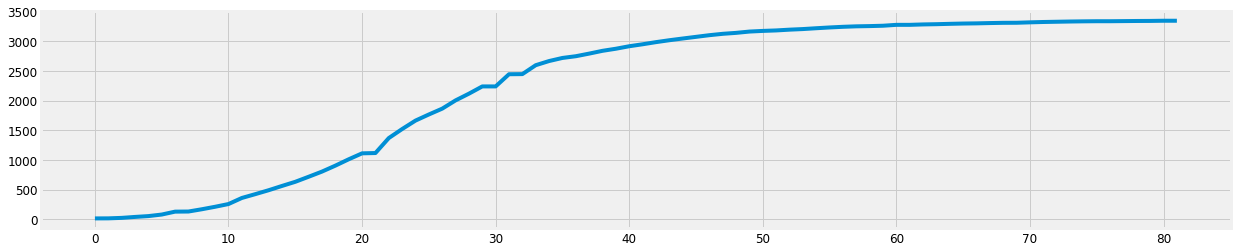

In [42]:
#y.Austria= df_transpose.set_index(['Date'])
df_transpose.China.plot(figsize=(19, 4))
plt.show()

df_china = df_transpose
df_austria = df_transpose

In [43]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df_austria['Austria'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.827971
p-value                         0.810767
#Lags Used                     11.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [44]:
print(adfuller(df_transpose['Austria']))
print(adfuller(df_transpose['China']))

(-0.8279714259257718, 0.8107672945023334, 11, 70, {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}, 361.0460906902703)
(-3.5931496579904016, 0.005893350201736048, 10, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, 681.7047203195191)


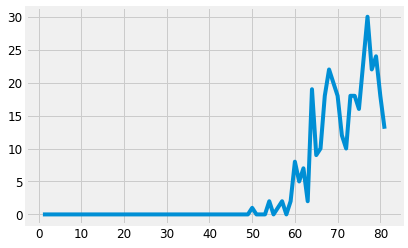

In [45]:
df_austria['Austria_Diff'] = df_austria['Austria'] - df_austria['Austria'].shift(1)
df_austria['Austria_Diff'].plot()

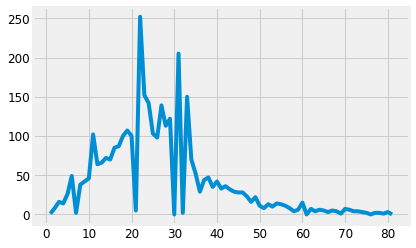

In [10]:
df_china['China_Diff'] = df_china['China'] - df_china['China'].shift(1)
df_china['China_Diff'].plot()

In [0]:
#Set-up a dataframe for the actual results
df_actual = df_transpose
steps=1
df_actual['Austria']=df_actual['Austria'] - df_actual['Austria'].shift(steps)
df_actual['Sweden']=df_actual['Sweden'] - df_actual['Sweden'].shift(steps)
df_actual['Switzerland']=df_actual['Switzerland'] - df_actual['Switzerland'].shift(steps)
df_actual['Germany']=df_actual['Germany'] - df_actual['Germany'].shift(steps)
df_actual['United Kingdom']=df_actual['United Kingdom'] - df_actual['United Kingdom'].shift(steps)
df_actual['China']=df_actual['China'] - df_actual['China'].shift(steps)

##Prep Time Series for RNN

In [0]:
#Convert Series for Supervised Learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [48]:
# load dataset
data = df_transpose.loc[:,'Afghanistan':'Yemen']
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.tail())

    var1(t-1)  var2(t-1)  var3(t-1)  ...  var181(t)  var182(t)  var183(t)
77   0.777778   0.956522   0.658703  ...        0.5        0.0        0.0
78   0.777778   0.956522   0.699659  ...        0.5        0.0        0.0
79   0.833333   1.000000   0.802048  ...        1.0        0.0        0.0
80   0.833333   1.000000   0.873720  ...        1.0        0.0        0.0
81   1.000000   1.000000   0.938567  ...        1.0        0.0        0.0

[5 rows x 366 columns]


In [0]:
reframed.head(20)

##Add Features for Regression

In [0]:
#Create a dataframe with the list of Features to be used
df_features = df_country[['country', 'covid_confirmed_4_6_20','covid_deaths_4_6_20', 'covid_recovered_4_6_20', 'covid19_first_date','Population_2020', 'Density_KM2m', 'Median_age', ]]
df_features

#Calculate the number of days ago the first Covid19 case was reported
#12th April was when the dataset was downloaded
d = datetime(2020, 4, 12, 00, 00)

df_features['covid19_first_date'] = df_features['covid19_first_date'].astype('datetime64[ns]')
df_features['first_date_days'] = (d - df_features['covid19_first_date']).dt.days

#Set covid19_first_date as a number from the most recent figure
#df_features['covid19_first_date'] = (d - df_features['covid19_first_date']).dt.days

In [0]:
#Add Tests per 1M to the df_features dataframe
df_features = df_features.merge(df_world[['Country','Tests per 1M']], left_on='country', right_on='Country', how='left')
df_features.drop(['Country'], axis=1)


In [0]:
#Calculate the Average number of deaths for the last 20 days
col = df_deaths.loc[: , '3/25/20':'4/12/20']
df_deaths['last_20_avg'] = col.mean(axis=1)
df_mean = df_deaths[['Province/State','Country/Region','last_20_avg']]
df_mean.drop(['Province/State'],axis=1, inplace=True)
df_mean = df_mean.groupby(['Country/Region']).sum()

#Now add this new columnd to the df_feature dataframe
df_features = df_features.merge(df_mean[['last_20_avg']], left_on='country', right_on='Country/Region', how='left')

In [0]:
#Set all NaN to 0
df_features.fillna(0, inplace=True)

#Remove all commas from strings, so they can be converted to numbers
df_features['Density_KM2m'].replace(",", "", inplace=True)

#Remove N.A. value and replace with 0
df_features=df_features.replace('N.A.','0')

#Divide population by 1M, so the intercept is not so large
df_features['Population_2020'] = df_features['Population_2020']/1000000

#Update Median Age type
df_features['Median_age'] = df_features['Median_age'].astype(int)

In [0]:
#Create the feature of no. of days to reach 1 death per million
df_deaths_pm = df_deaths.merge(df_country[['country','Population_2020']], left_on='Country/Region', right_on='country', how='left')
df_deaths_pm.drop(['country', 'Lat', 'Long'],axis=1,inplace=True)
df_deaths_pm = df_deaths_pm.groupby(['Country/Region']).sum()
df_deaths_pm['Population_2020'] = df_deaths_pm['Population_2020']/1000000
df_deaths_pm['Population_2020'].fillna(0, inplace=True)
#df_deaths_pm['Province/State'].fillna('', inplace=True)

In [0]:
#Loop through the data and determine when the number of deaths
#exceeds 1 death per million people
df_deaths_pm['time_to_1m'] = ''
for index, row in df_deaths_pm.iterrows():
    for col, r2 in df_deaths_pm.iteritems():
        if col == 'Country/Region' or col == 'last_20_avg' or col == 'Population_2020' or col == 'time_to_1m':
              continue
        if row[col] > row['Population_2020']:
            df_deaths_pm.at[index, 'time_to_1m'] = str(col)
            break

#Now merge the column with the df_features dataframe
df_val = pd.merge(df_features, df_deaths_pm, left_on='country', right_on='Country/Region',how='left')
df_val = df_val.filter(['country','covid19_first_date','time_to_1m'], axis=1)
df_val['time_to_1m'] = df_val['time_to_1m'].astype('datetime64[ns]')
df_val = df_val.fillna(datetime(2020, 4, 30, 00, 00))
df_val['days_to_1m'] = (df_val['time_to_1m'] - df_val['covid19_first_date']).dt.days
#df_features = pd.merge(df_features, df_val[['country', 'days_to_1m']], on='country', how='left')

#Drop Country data to feed to model
df_features.drop(['Country', 'country', 'covid19_first_date'], axis=1, inplace=True)

#Create the Y value, which is the Deaths per 1M in population
df_features['Y'] = np.where(df_features.Population_2020>0., df_features.covid_deaths_4_6_20/df_features.Population_2020, 0.)


#Build Models



##Linear Regression

In [0]:
#https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f
X = df_features.loc[:, df_features.columns != 'Y']
Y = df_features.loc[:, df_features.columns == 'Y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
columns = X_train.columns

In [276]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(X_train_scaled)
X_test = pd.DataFrame(X_test_scaled)

model_lin = LinearRegression() 
model_lin.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [277]:
print(model_lin.intercept_)

print(model_lin.coef_)

[21.15843836]
[[-12.93555566  33.54602131   3.48506753  -2.06970263  -2.11753642
  -22.94363716   5.9514612   21.00902751  10.49130044]]


In [0]:
pred_lin = model_lin.predict(X_test)

In [279]:
#Calculat the RMSE to help determine the level of accuracy
#rmse = sqrt(mean_squared_error(Y_test, pred_lin))

print('MAE - '+ str(mean_absolute_error(Y_test, pred_lin)))
print('MSE - '+ str(mean_squared_error(Y_test, pred_lin)))
print ('RMSE - ' + str(sqrt(mean_squared_error(Y_test, pred_lin))))
print('R-Squared - ' + str(r2_score(Y_test, pred_lin)))

MAE - 14.82829716618535
MSE - 352.3187111003956
RMSE - 18.77015479692151
R-Squared - -1.9360508469990316


##KNN Regression

In [0]:
#https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

X = df_features.loc[:, df_features.columns != 'Y']
Y = df_features.loc[:, df_features.columns == 'Y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

In [0]:
rmse_knn = [] #to store rmse values for different k
for K in range(120):
    K = K+1
    model_knn = neighbors.KNeighborsRegressor(n_neighbors = K)

    model_knn.fit(X_train, Y_train)  #fit the model
    pred=model_knn.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    rmse_knn.append(error) #store rmse values

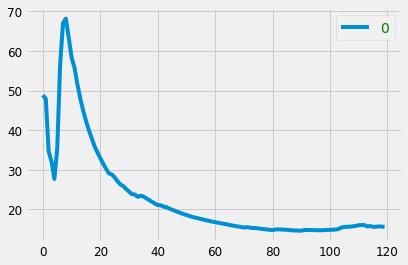

In [283]:
#Plot RMSE values
curve = pd.DataFrame(rmse_knn) 
curve.plot()

In [284]:
#Best value for K is 91
model_knn = neighbors.KNeighborsRegressor(n_neighbors=91)
model_knn.fit(X_train, Y_train)
pred_knn = model_knn.predict(X_test)
model_knn.score(X_train, Y_train)

0.0036749061976897317

In [285]:
print('MAE - '+ str(mean_absolute_error(Y_test, pred_knn)))
print('MSE - '+ str(mean_squared_error(Y_test, pred_knn)))
print ('RMSE - ' + str(sqrt(mean_squared_error(Y_test, pred_knn))))
print('R-Squared - ' + str(r2_score(Y_test, pred_knn)))

MAE - 11.094827667061038
MSE - 213.5003230257081
RMSE - 14.611650249910449
R-Squared - -0.7792066799301289


##Random Forest Regression

In [0]:
X = df_features.loc[:, df_features.columns != 'Y']
Y = df_features.loc[:, df_features.columns == 'Y']

In [0]:
#scaler = MinMaxScaler(feature_range=(0, 1))

#X_train_scaled = scaler.fit_transform(X_train)
#X_train = pd.DataFrame(X_train_scaled)

#X_test_scaled = scaler.fit_transform(X_test)
#X_test = pd.DataFrame(X_test_scaled)

In [0]:
#Split into test and train set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

#Normalise the data
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train = pd.DataFrame(X_train_scaled)
X_test = pd.DataFrame(X_test_scaled)

In [0]:
rmse_rf=[]
for est in range(50):
    est = est+1
    model_rf = RandomForestRegressor(n_estimators= est, random_state=45)

    model_rf.fit(X_train, Y_train) 
    pred=model_rf.predict(X_test) 
    error = sqrt(mean_squared_error(Y_test,pred))
    rmse_rf.append(error) 

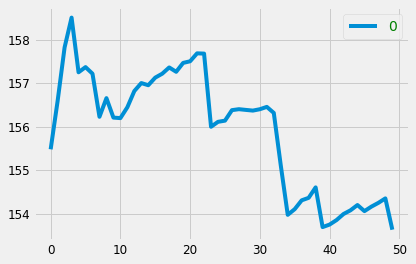

In [289]:
#Plot RMSE values
curve = pd.DataFrame(rmse_rf) 
curve.plot()

In [0]:
model_rf = RandomForestRegressor(n_estimators=38, random_state=45)
model_rf.fit(X_train, Y_train)

pred_rf = model_rf.predict(X_test)

In [291]:
error = sqrt(mean_squared_error(Y_test,pred))
print(error)
print(model_rf.feature_importances_)

153.6337344524334
[0.08536147 0.22177432 0.03360008 0.02860457 0.01139055 0.03039347
 0.10185961 0.18229479 0.30472115]


In [292]:
print('MAE - '+ str(mean_absolute_error(Y_test, pred_rf)))
print('MSE - '+ str(mean_squared_error(Y_test, pred_rf)))
print ('RMSE - ' + str(sqrt(mean_squared_error(Y_test, pred_rf))))
print('R-Squared - ' + str(r2_score(Y_test, pred_rf)))

MAE - 34.42688635478878
MSE - 23828.94429174617
RMSE - 154.36626668979906
R-Squared - 0.04828696820407474


##Bayesian Regression

In [0]:
#Split into test and train set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

#Normalise the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [0]:
rmse_bay=[]
for i in range(20):
    i = i+1
    model_bay=linear_model.BayesianRidge(n_iter=i)

    model_bay.fit(X_train, Y_train)
    pred=model_bay.predict(X_test) 
    error = sqrt(mean_squared_error(Y_test,pred))
    rmse_bay.append(error) 

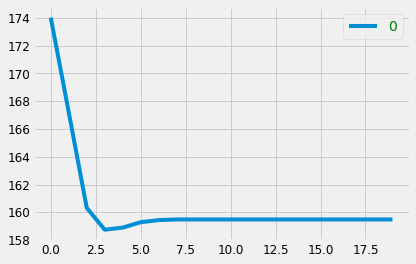

In [295]:
#Plot RMSE values
curve = pd.DataFrame(rmse_bay) 
curve.plot()

In [0]:
model_bay=linear_model.BayesianRidge(n_iter=3)

model_bay.fit(X_train, Y_train)
pred_bay=model_bay.predict(X_test) 

In [297]:
print('MAE - '+ str(mean_absolute_error(Y_test, pred_bay)))
print('MSE - '+ str(mean_squared_error(Y_test, pred_bay)))
print ('RMSE - ' + str(sqrt(mean_squared_error(Y_test, pred_bay))))
print('R-Squared - ' + str(r2_score(Y_test, pred_bay)))

MAE - 40.46699504804309
MSE - 25703.152466889536
RMSE - 160.32202739140226
R-Squared - -0.02656772626932824


##Ensemble of Regressions

In [0]:
final_pred=(pred_lin*0.5+pred_lin*0.5)

In [211]:
print('MAE - '+ str(mean_absolute_error(Y_test, final_pred)))
print('MSE - '+ str(mean_squared_error(Y_test, final_pred)))
print ('RMSE - ' + str(sqrt(mean_squared_error(Y_test, final_pred))))

MAE - 14.82829716618535
MSE - 352.3187111003956
RMSE - 18.77015479692151


##SEIR Model

Builds the modified SEIR model using code from Gitlab. Also caters for a change in R0 (R-zero) for when restrictions were implemented

In [0]:
#Modified SEIR model
#Reference for this code is: 
#https://github.com/hf2000510/infectious_disease_modelling/blob/master/part_two.ipynb


In [0]:
def plotseird(country, t, S, E, I, R, D=None, L=None, R0=None, Alpha=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title(country + " - Lockdown after {} days".format(L))
  plt.show();

  #if R0 is not None or CFR is not None:
  if R0 is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt


In [0]:
def run_seir_model(N, L, country):
  #N = 1_000_000
  D = 4.0 # infections lasts four days
  gamma = 1.0 / D
  delta = 1.0 / 5.0  # incubation period of five days

  #R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

  def R_0(t):
      return 5.0 if t < L else 1.2
  def beta(t):
      return R_0(t) * gamma

  alpha = 0.2  # 20% death rate
  rho = 1/9  # 9 days from infection until death
  S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

  t = np.linspace(0, 200, 200) # Grid of time points (in days)
  y0 = S0, E0, I0, R0, D0 # Initial conditions vector

  # Integrate the SIR equations over the time grid, t.
  ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
  S, E, I, R, D = ret.T
  #R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

  plotseird(country, t, S, E, I, R, D, L)
  return S, E, I, R, D

In [0]:
#S, E, I, R, D = run_seir_model(df_seir_test.Population_2020[5], df_seir_test.Difference[5].round())
#print(D[-1])
deaths = []
for index, row in df_seir_test.iterrows():
    S, E, I, R, D = run_seir_model(df_seir_test.Population_2020[index], df_seir_test.Difference[index].round(), df_seir_test.country[index])
    deaths.append(D[-1])

df_seir_test['Deaths'] = deaths
df_seir_test['Fatality Rate'] = df_seir_test['Deaths']/df_seir_test['Population_2020'] * 100

In [161]:
df_seir_test.head(20)

,country,min_date,max_date,covid19_first_date,Population_2020,Difference,Deaths,Fatality Rate
2,Australia,2020-03-23,2020-03-23,2020-01-23 12:00:00,2.549988e+07,59.500000,2.111682e+06,8.281144
4,Egypt,2020-03-19,2020-03-19,2020-02-14 22:00:00,1.023344e+08,33.083333,6.919270e+05,0.676143
5,France,2020-03-16,2020-03-16,2020-01-24 12:00:00,6.527351e+07,51.500000,3.362979e+06,5.152135
8,India,2020-03-03,2020-03-24,2020-01-30 21:30:00,1.380004e+09,32.104167,6.236468e+05,0.045192
9,Italy,2020-02-23,2020-02-23,2020-01-30 21:30:00,6.046183e+07,23.104167,6.211875e+04,0.102740
10,Japan,2020-02-27,2020-02-27,2020-01-22 12:00:00,1.264765e+08,35.500000,1.340916e+06,1.060210
14,Lebanon,2020-03-18,2020-03-18,2020-02-21 22:00:00,6.825445e+06,25.083333,7.890941e+04,1.156106
18,Netherlands,2020-03-23,2020-03-23,2020-02-27 22:00:00,1.713487e+07,24.083333,7.415820e+04,0.432791
19,Nigeria,2020-03-20,2020-03-20,2020-02-28 22:00:00,2.061396e+08,20.083333,2.950043e+04,0.014311
22,Spain,2020-03-15,2020-03-25,2020-01-31 19:00:00,4.675478e+07,43.208333,1.846761e+06,3.949888


In [27]:
df_seir_test.country[index]

'Australia'

##Time Series Model Using ARIMA

In [132]:
data = df_austria['Austria_Diff'].dropna().values
data = df_actual['Sweden'].dropna().values
mod = ARIMA(data, order=(2,0,1))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3976      8.539      1.218      0.227      -6.338      27.133
ar.L1.y        0.2242      0.097      2.309      0.024       0.034       0.415
ar.L2.y        0.5010      0.097      5.161      0.000       0.311       0.691
ma.L1.y        1.0000      0.035     28.851      0.000       0.932       1.068


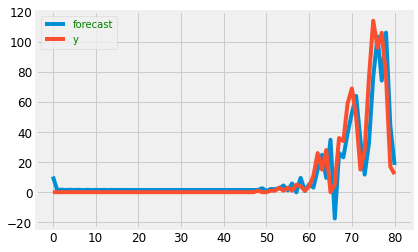

In [133]:

results.plot_predict(dynamic=False)
plt.show()

In [0]:
print(results.summary())

In [0]:
#Use ARIMA to predict for each country
#!pip install pyramid.arima
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
swed = df_actual['Sweden'].dropna().values
modx = SARIMAX(swed, order=(1,1,0), measurement_error=True)



In [129]:
pred = modx.fit()
pred.forecast(10)

array([10.92697097, 10.69669272, 10.64727366, 10.63666805, 10.63439202,
       10.63390357, 10.63379875, 10.63377625, 10.63377143, 10.63377039])

In [131]:
swed

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   3.,   1.,
         3.,   1.,   5.,   4.,   1.,   4.,  11.,  26.,  15.,  28.,   0.,
         5.,  36.,  34.,  59.,  69.,  50.,  15.,  28.,  76., 114.,  96.,
       106.,  77.,  17.,  12.])

In [0]:
#Scale the data
df_actual = df_actual.fillna(0)
sc_in = MinMaxScaler(feature_range=(0, 1))
#Would it make sense to add in other countries as "features" here???
scaled_input = sc_in.fit_transform(df_actual[['China']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(df_actual[['Austria']])
scaler_output = pd.DataFrame(scaler_output)
y=scaler_output

In [0]:
X = pd.DataFrame(df_actual['China'][40:])
y = pd.DataFrame(df_actual['Austria'][40:])

In [0]:
#Setup train/test data
#train_size=int(len(X) *0.7)
#test_size = int(len(X)) - train_size
#train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
#test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)

In [369]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(29, 1)
(29, 1)
(13, 1)
(13, 1)


In [0]:
#Perform a step wise search for the best model parameters
from pmdarima.arima import auto_arima

step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

In [0]:
step_wise.summary()

In [0]:
#Train the SARIMAX model
mod_arimax = smx.tsa.SARIMAX(train_y, exog=train_X, order=(2,1,1),
                            enforce_invertibility=False, enforce_stationarity=False)

mod_res = mod_arimax.fit()
mod_res.summary()

In [0]:
res = mod_res.predict(start =train_size, end=train_size+test_size+(steps)-2, exog=test_X)

In [0]:
res

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
m = SARIMAX(train_y, 
 exog=train_X,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [0]:
results = m.fit()

In [0]:
forecast_1= results.forecast(steps=test_size+1, exog=test_X)

In [0]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple['Actual'] =scaler_output.iloc[train_size:, 0]
forecast_apple.rename(columns={0:'Forecast'}, inplace=True)

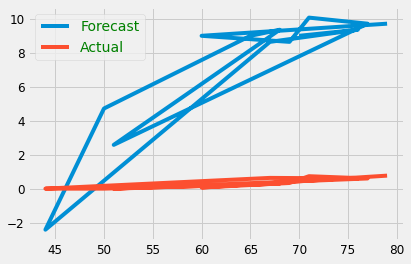

In [384]:
forecast_apple['Forecast'].plot(legend=True)
forecast_apple['Actual'].plot(legend=True)

##Time Series Model using LSTM

In [111]:
#split into train and test sets
values = reframed.values
n_train_hours = 100
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
#train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
train_X, test_X, train_y, test_y = train_test_split(train[:, :-1], train[:, -1], test_size=0.6, random_state=0)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(32, 1, 365) (32,) (48, 1, 365) (48,)


In [0]:
#Design Model
model = Sequential()
model.add(LSTM(365, input_shape=(train_X.shape[1], train_X.shape[2]),
                return_sequences=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
#Had to remove the validate_Data to get this to work.....it was throwing a very strage error before that
history = model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
# make a prediction
yhat = model.predict(test_X)

In [0]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [0]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat[:,0], test_X[:, 1:]), axis=1)

In [116]:

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

#Evaluation of Models

#Conclusion